# CTD Analysis

In [50]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cmocean
import numpy as np
from geopy import distance
import glob
import gsw
import warnings
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

## Functions

In [51]:
def plots_S_T(inds, title):

    vmin_s = 34.6
    vmax_s = 35.4
    vmin_t = 0
    vmax_t = 27
    
    # Create a figure with 1 row and 3 columns for subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{title}', fontsize=14) 
    # Plot the trajectory on the first subplot (small figure)
    axes[0].plot(ctd.lon.isel(obs=0), ctd.lat.isel(obs=0), label='Full Trajectory')
    axes[0].plot(ctd.lon.isel(obs=0, trajectory=inds), ctd.lat.isel(obs=0, trajectory=inds), label='South Trajectory', color='red')
    axes[0].set_title("Transect")
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].grid()
    axes[0].legend(loc='upper left')
    
    # Plot salinity on the second subplot (large figure)
    ctd_transsect = ctd_descent.isel(trajectory=inds)
    lons = ctd_transsect.lon.isel(depth=0)
    depths = ctd_transsect.depth
    salinity_plot = axes[1].pcolormesh(lons, depths, ctd_transsect.salinity.transpose(), shading='nearest', clim=(vmin_s, vmax_s),cmap =  cmocean.cm.haline )
    axes[1].set_title("Salinity")
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Depth")
    # Add colorbar for salinity plot
    fig.colorbar(salinity_plot, ax=axes[1], label="Salinity")
    
    # Plot temperature on the third subplot (large figure)
    ctd_transsect = ctd_descent.isel(trajectory=inds)
    lons = ctd_transsect.lon.isel(depth=0)
    depths = ctd_transsect.depth
    temperature_plot = axes[2].pcolormesh(lons, depths, ctd_transsect.temperature.transpose(), shading='nearest', clim=(vmin_t, vmax_t), cmap = cmocean.cm.thermal)
    axes[2].set_title("Temperature")
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Depth")
    # Add colorbar for temperature plot
    fig.colorbar(temperature_plot, ax=axes[2], label="Temperature (°C)")
    
    # Adjust layout to ensure subplots are nicely spaced
    plt.tight_layout()
    
    # Show the plot
    plt.show()

## Preparing the data

In [52]:
#loading the data
datadir = r'/Users/areti/Downloads/results2/somalia/results/ctd.zarr'
ctd = xr.open_zarr(datadir).compute()
ctd

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB 5.03 5.03 5.03 ... nan nan nan
    lon          (trajectory, obs) float32 98kB 49.45 49.45 49.45 ... nan nan
    max_depth    (trajectory, obs) float32 98kB -2.776e+03 -2.776e+03 ... nan
    min_depth    (trajectory, obs) float32 98kB -11.0 -11.0 -11.0 ... nan nan
    raising      (trajectory, obs) float32 98kB 0.0 0.0 0.0 0.0 ... nan nan nan
    salinity     (trajectory, obs) float32 98kB 34.97 34.97 34.98 ... nan nan
    temperature  (trajectory, obs) float32 98kB 26.26 26.26 26.26 ... nan nan
    time         (trajectory, obs) datetime64[ns] 196kB 2024-09-17T23:12:00 ....
    winch_speed  (trajectory, obs) float32 98kB 1.0 1.0 1.0 1.0 ... nan nan nan
    z            (trajectory, obs) float32 98kB -11.0 -21.0 -31.0 ... nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticle_sample_salinity_sample_temperature_ct...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [53]:
# take difference in obs direction
# during descent: diff < 0
dz = ctd.z.diff('obs') 
# using the 'diff' operator reduces the axis size by one
# copy dummy data (first obs entry of original array) to fill it up again
dz = xr.concat([dz.isel(obs=0),dz],dim='obs')
dz = dz.load()
dz['obs'] = np.arange(0,dz.obs.count()) # fixes bug where 'obs' index would occur double

In [54]:
# choose only the descent
ctd_descent = ctd.where(dz<0).compute()

#Cut off the nan entries that occur after a certain value obs_max
obs_max = int(ctd.z.argmin(dim='obs').max().compute())
ctd_descent = ctd_descent.isel(obs=slice(0,obs_max))

# find maximum depth over all the trajectories
traj_maxdepth = ctd.z.argmin(dim='obs').argmax(dim='trajectory').compute()
ctd_descent['obs'] = ctd_descent.z.isel(trajectory=traj_maxdepth)
ctd_descent = ctd_descent.rename({'obs':'depth'})


## Salinity and Temperature Plots

In [55]:
#indices for transects (south to north) 
trs1_idx = slice(0,8) #transect 1
trs2_idx = slice(8,16) #transect 2
trs3_idx = slice(16,24) #transect 3 

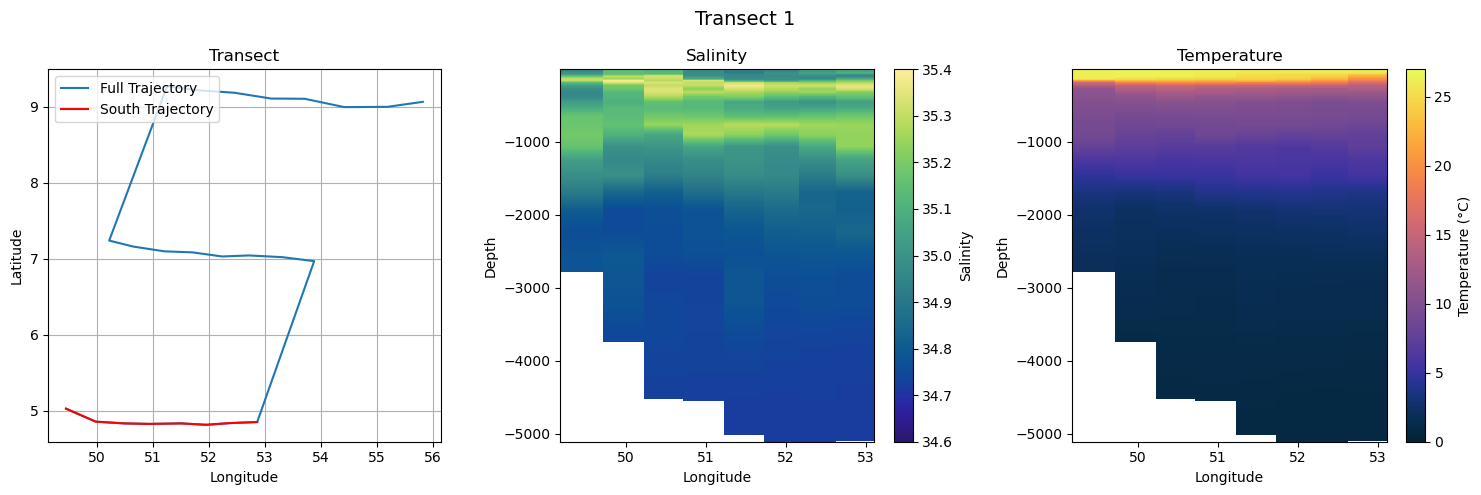

In [56]:
plots_S_T(inds= trs1_idx, title = 'Transect 1')

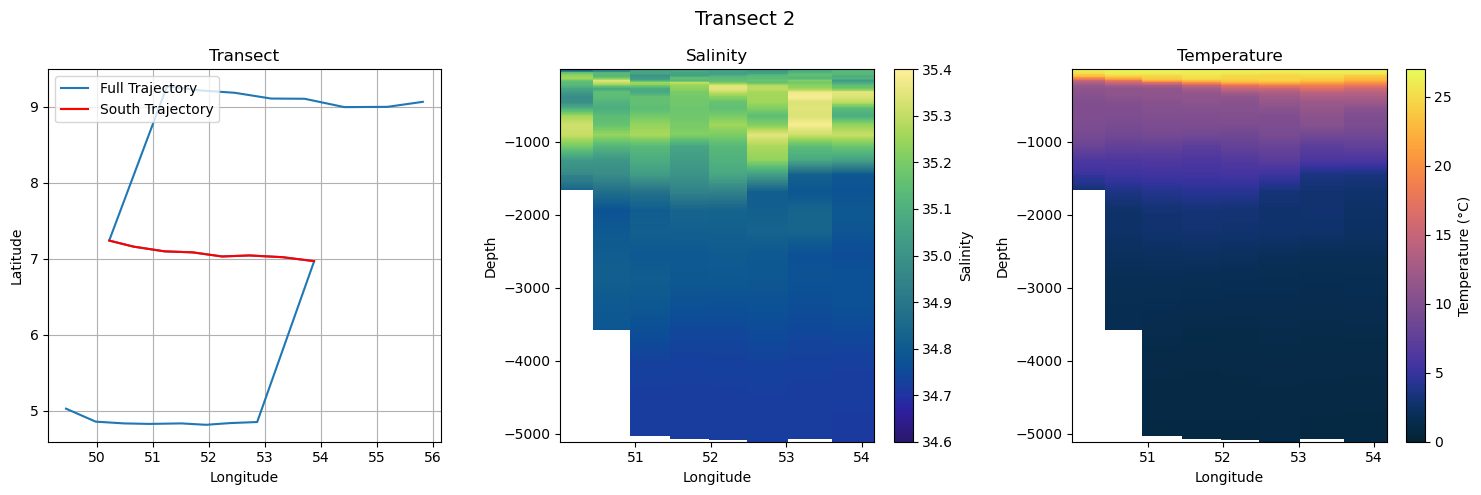

In [41]:
plots_S_T(inds= trs2_idx, title = 'Transect 2')

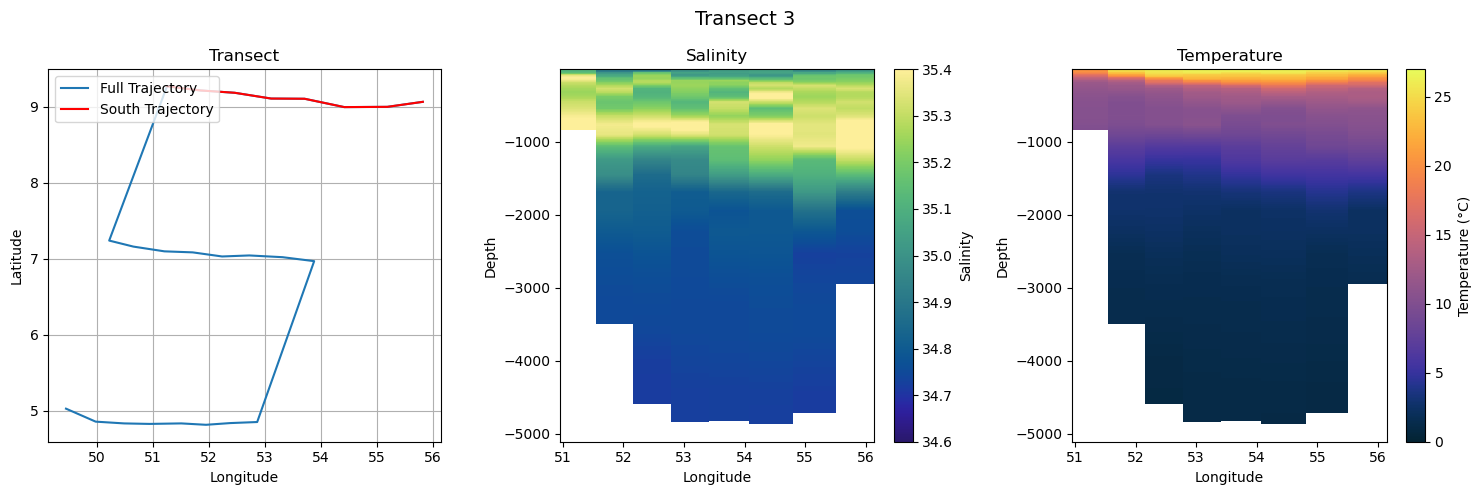

In [42]:
plots_S_T(inds= trs3_idx, title = 'Transect 3')

## Calculating density and velocity profiles 

In [63]:
# Constants
alpha_T = 1e-4  # Thermal expansion coefficient
beta_S = 7e-4   # Haline contraction coefficient
dens0 = 1027    # Reference density (kg/m³)

def calc_density(data, plot=False):
    """
    Calculate density from a profile containing salinity, temperature, and depth.
    
    Parameters:
        profile (dict): A dictionary containing 'salinity', 'temperature', 'z', and 'trajectory'.
    """
    S = data['salinity']
    T = data['temperature']
    depth = data['depth']

    # Reference salinity and temperature (surface value)
    S0 = S.isel(depth = 0)   #S[0] this selects the trajectory with index 0  
    T0 = T.isel(depth = 0)

    # Calculate density
    dens = dens0 * (1 - (alpha_T * (T - T0)) + (beta_S * (S - S0)))

    # # Plot
    # if plot==True:
    #     plt.figure(figsize=(8, 6))
    #     plt.plot(dens, -depth, 'o-', label=f"Trajectory {profile['trajectory']}")
    #     plt.xlabel('Density (kg/m³)')
    #     plt.ylabel('Depth (m)')
    #     plt.title('Density Profile')
    #     plt.grid()
    #     plt.legend()
    #     plt.show()

    return dens

In [65]:
ctd_transsect = ctd_descent.isel(trajectory=trs1_idx)
dens = calc_density(data = ctd_transsect , plot=False)

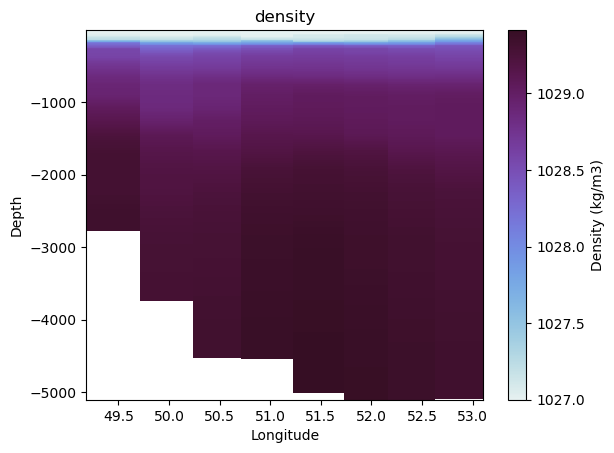

In [68]:
lons = ctd_transsect.lon.isel(depth=0)
depths = ctd_transsect.depth
dens_plot = plt.pcolormesh(lons, depths, dens.transpose(), shading='nearest', cmap= cmocean.cm.dense)

plt.title("density")
plt.xlabel("Longitude")
plt.ylabel("Depth")
# Add colorbar for temperature plot
plt.colorbar(dens_plot, label="Density (kg/m3)")

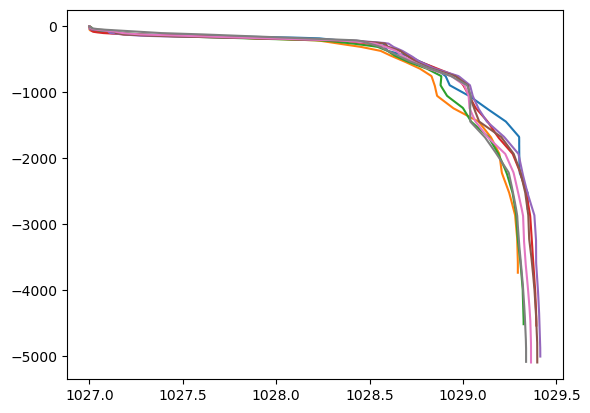

In [71]:
#densities at each stop
for i in range(8):
    plt.plot(dens[i], depths)

# Haven't looked at it yet 

## other than sara's plots I get a strange figure. 
it seems that the first calculated density profile is 1 value. other than that, the densities show unstable stratification


### a few comments on sara's code:
1. The code subtracts u[:, -1:] to set the velocity at the surface to zero, assuming there is no motion at the surface. However, we think that the current velocity is wind-induced and therefore the biggest at the surface. We should take a lower level depth to be zero in order to calculate this surface flow velocity.
2. The calculation of du_dz (and afterward integration) assumes that the density is now a reference density rho_0. however, we know that density changes with depth. in the original thermal wind equations this rho is not a reference density but just rho 
3. drho_dx = np.gradient(density_interp, dx, axis=0)   tries to calculate the horzontal density gradient. however, by this time you haven't yet calculated the distance between the casts. therefore this might not be correct?
### Now I will try to calculate the density using a more accurate equation of state
using  TEOS10 equations from practical A03_1

In [71]:
import gsw

In [72]:
ctd

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB 5.03 5.03 5.03 ... nan nan nan
    lon          (trajectory, obs) float32 98kB 49.45 49.45 49.45 ... nan nan
    max_depth    (trajectory, obs) float32 98kB -2.776e+03 -2.776e+03 ... nan
    min_depth    (trajectory, obs) float32 98kB -11.0 -11.0 -11.0 ... nan nan
    raising      (trajectory, obs) float32 98kB 0.0 0.0 0.0 0.0 ... nan nan nan
    salinity     (trajectory, obs) float32 98kB 34.97 34.97 34.98 ... nan nan
    temperature  (trajectory, obs) float32 98kB 26.26 26.26 26.26 ... nan nan
    time         (trajectory, obs) datetime64[ns] 196kB 2024-09-17T23:12:00 ....
    winch_speed  (trajectory, obs) float32 98kB 1.0 1.0 1.0 1.0 ... nan nan nan
    z            (trajectory, obs) float32 98kB -11.0 -21.0 -31.0 ... nan nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticle_sample_salinity_sample_temperature_ct...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

In [ ]:
# lat = data[6]['LATITUDE'].values
# consT = gsw.conversions.CT_from_t(S[0,:], T[0,:], P[0,:])
# dens_insitu = gsw.density.rho(S[0,:], consT, P[0,:])
# depth = gsw.conversions.z_from_p(P[0,:], lat)

lons = ctd_transsect.lon.isel(depth=0)
depths = ctd_transsect.depth

consT = gsw.conversions.CT_from_t(

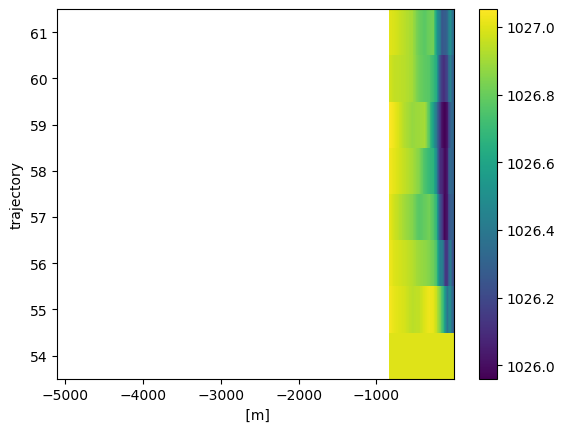

In [40]:
inds = slice(8,16)
dens = calc_density(ctd_transsect)
dens.plot()

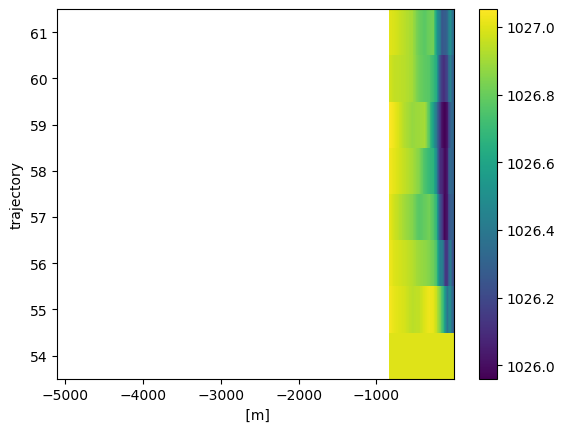

In [39]:
inds = slice(16,24)
dens = calc_density(ctd_transsect)
dens.plot()